# Stack Overflow Post Categorisation

In this project, we aim to build a system to compile common challenges faced by software developers along with their solutions. The challenges compiled in this system will be related to NLP and will be categorise based on the **xxx**.

The challenges and solutions are collected from Stack Overflow, which is commonly used among developers to share their problem in the discussion forums. The solution provided on Stack Overflow are written by experience developers, making them more credible compared to ChatGPT. Therefore, with this system, we aim to categorise each post to increase efficiency in finding solution to any challenges related to NLP within developers in our company.

# 1. Data collection

We begin with collecting the challenges and solutions from Stack Overflow using Stack Exchange API. The documentation provided by the Stack Exchange API offers a comprehensive explanation on how to utilize their API to collect the desired data [1].

In Stack Overflow, each post consist of a question, tags, and identifier indicating whether it has answer and whether it also has an accepted answer. An accepted answer means that the author who post a questions, received an answer that worked for them personally [2]. Often, this means the answer provided by the forum successfully resolve their issue. Other than that, each post also has one or more tags, which is a word or phrase that describes the topic of the question [3].

The data collected in our project includes questions and answers related to NLP topic. To obtain this, we retrieve data with tags related to NLP, mainly from the `nlp` tag, and we only retrieve posts that have an accepted answer. We utilize the advanced search feature provided by the Stack Exchange API that helps generate a URL that can meets our data request requirements [4]. Through this advanced search, we obtain a URL that retrieves posts with accepted answers relevant to our tags.

The result provide us with the accepted answer id, which we will use to request the answer body from the API. Therefore, we will perform two data request to the API, one for posts (containing the question, tags, and accepted answer id) and another for the accepted answer content. So, in the end, we will connect both results to obtain a single file that compiles posts consisting of questions and its accepted answer.

In [ ]:
# Supress warnings to remove less necessary warnings
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [ ]:
import requests
import json

# Define a class to perform data collection
class get_stackoverflow_data:

  # 1. Initialise variables
  def __init__(self, tag, num_of_data, filename, only_collective=False, not_accepted_answer=False):

    self.tags = tag
    self.num_of_data = num_of_data
    self.filename = filename
    self.params = {
        "site": "stackoverflow",
        "filter": "withbody",
        "pagesize": 100,
        "key": "rl_MFjddDouDky4bfDeQMEA5WDN3"}
    self.only_collective = only_collective
    self.not_accepted_answer = not_accepted_answer

    # Initialise empty variables to store the results
    self.posts = []
    self.post_ids = set()
    self.num_of_retrieved_data = 0


  # 2. Function to perform loop data request for posts (questions)
  def get_posts_loop(self, post_url, tag=None):

      page = 1

      while self.num_of_retrieved_data < self.num_of_data:

        if self.only_collective:
          self.post_params["collective"] = "nlp"
        else:
          self.post_params["tagged"] = tag

        self.post_params["page"] = page

        get_posts_with_accepted_answer_id = requests.get(post_url, params=self.post_params).json()

        # The data sucessfully retrieved indicated with 'items' keys in the output
        if "items" in get_posts_with_accepted_answer_id:

          # Check the 'question_id' to avoid duplicated posts
          for post in get_posts_with_accepted_answer_id['items']:

            if post['question_id'] not in self.post_ids and post['answer_count'] > 0:

              self.posts.append(post)
              self.post_ids.add(post['question_id'])
              self.num_of_retrieved_data += 1

              if self.num_of_retrieved_data >= self.num_of_data:
                break

          page += 1

        else:
          # Exit if no more result contained
          break


  # 3. Function to specify parameters for different posts (questions) request
  def get_stackoverflow_posts(self):

    # Finalise the parameters and URL that want to be used to retrieve posts from the API
    self.post_params = self.params.copy()

    if not self.not_accepted_answer:
      # Get posts that has accepted answer with advanced search url
      post_url = "https://api.stackexchange.com/2.3/search/advanced?order=desc&sort=activity&accepted=True"
    else:
      # Get posts that has at least one answer
      post_url = "https://api.stackexchange.com/2.3/questions"

     # Retrieve post data from 'NLP' collective
    if self.only_collective:
      self.get_posts_loop(post_url)

    # Perform looping to retrieve post data from multiple tags
    for tag in self.tags:
      self.get_posts_loop(post_url, tag)

    # Print a message if the target number of data has not been achieved
    if self.num_of_retrieved_data < self.num_of_data:
      print("The requested number of data exceeds the currently available data.")

    if self.only_collective:
      print(f"Total {self.num_of_retrieved_data} posts sucessfully retrieved from the \"NLP\" collective.")
    else:
      print(f"Total {self.num_of_retrieved_data} posts sucessfully retrieved from the \"{self.tags}\" tags.")


  # 4. Function to perform data request for accepted answer based on collected questions using aceppted_answer_id
  def get_stackoverflow_answers(self):

    # Compile the accepted_answer_id into a list
    accepted_answer_ids = []

    for post in self.posts:
        accepted_answer_ids.append(str(post['accepted_answer_id']))

    # Return the answer 'body' into a dictionary with format: 'answer_id' as the key and 'body' as the value
    self.answer_body = {}

    # Perform looping since the max size for each request are 100 semicolon delimited ids
    for page in range(0, len(accepted_answer_ids), self.params['pagesize']):

      sliced_accepted_answer_ids = accepted_answer_ids[page:page+self.params['pagesize']]

      accepted_answer_ids_str = ";".join(sliced_accepted_answer_ids)

      # Get the accepted answer body with filtering by 'accepted_answer_id' for each post
      answer_url = f"https://api.stackexchange.com/2.3/answers/{accepted_answer_ids_str}"

      get_answer_body = requests.get(answer_url, params=self.params).json()

      for answer in get_answer_body["items"]:
        self.answer_body[answer['answer_id']] = answer['body']

    print(f"Total {len(self.answer_body)} accepted answered sucessfully retrieved from each posts.")

  # 5. Function to perform data request for highest score answer based on collected questions using question_id
  def get_top_stackoverflow_answers(self):

    # Compile the accepted_answer_id into a list
    question_id = []

    for post in self.posts:
        if post['answer_count'] > 0 and "answer_body" not in post:

          question_id.append(str(post['question_id']))

          answers_url = f"https://api.stackexchange.com/2.3/questions/{str(post['question_id'])}/answers"

          self.params["order"]= "desc"
          self.params["sort"] = "votes"

          get_answers_body = requests.get(answers_url, params=self.params).json()

          if "items" in get_answers_body:
            best_answer = get_answers_body["items"][0]

            # Append the answer to the posts
            post['accepted_answer_id'] = best_answer['answer_id']
            post['answer_body'] = best_answer['body']

          else:
            print(f"No answers found for question_id: {post['question_id']}")

    print(f"Total {len(question_id)} accepted answered sucessfully retrieved from each posts.")

  # 6. Function to combine collected questions and answers into a json file
  def get_stackoverflow_posts_answers(self):

    # Mapped the answer body by 'accepted_answer_id' into the posts question
    if not self.not_accepted_answer:
      for post in self.posts:
        post['answer_body'] = self.answer_body[post['accepted_answer_id']]

    # Save the result into a json file
    with open(self.filename, 'w') as file:
      json.dump(self.posts, file)

    print(f"Output successfully saved into {self.filename}.")

In [ ]:
### PART 1:
# Collecting posts from 'NLP' collective only
stackoverflow_collective_df = get_stackoverflow_data(tag=[], num_of_data=20000, filename='stack_overflow_posts_nlp_collective.json', only_collective=True)
stackoverflow_collective_df.get_stackoverflow_posts()

The requested number of data exceeds the currently available data.
Total 2500 posts sucessfully retrieved from the "NLP" collective.


In [ ]:
# Collecting accepted answer for 'NLP' collective and save into a json file
stackoverflow_collective_df.get_stackoverflow_answers()
stackoverflow_collective_df.get_stackoverflow_posts_answers()

Total 2500 accepted answered sucessfully retrieved from each posts.
Output successfully saved into stack_overflow_posts_nlp_collective.json.


In [ ]:
### PART 2:
# Collecting posts from multiple tags combination
tags_nlp_related = ["nlp","tokenize","recurrent-neural-network","python;text-classification","python;regex","machine-learning;text","python;lstm","python;visualisation"]
stackoverflow_df = get_stackoverflow_data(tag=tags_nlp_related, num_of_data=20000, filename='stack_overflow_posts_nlp.json')
stackoverflow_df.get_stackoverflow_posts()

The requested number of data exceeds the currently available data.
Total 9086 posts sucessfully retrieved from the "['nlp', 'tokenize', 'recurrent-neural-network', 'python;text-classification', 'python;regex', 'machine-learning;text', 'python;lstm', 'python;visualisation']" tags.


In [ ]:
# Collecting accepted answer for multiple tags combination and save into a json file
stackoverflow_df.get_stackoverflow_answers()
stackoverflow_df.get_stackoverflow_posts_answers()

Total 9086 accepted answered sucessfully retrieved from each posts.
Output successfully saved into stack_overflow_posts_nlp.json.


In [ ]:
### PART 3:
# Collecting posts with MORE tags combination
tags_nlp_related = ["machine-learning","deep-learning","python"]
stackoverflow_additional_df = get_stackoverflow_data(tag=tags_nlp_related, num_of_data=20000, filename='stack_overflow_posts_nlp_general.json')
stackoverflow_additional_df.get_stackoverflow_posts()

The requested number of data exceeds the currently available data.
Total 7096 posts sucessfully retrieved from the "['machine-learning', 'deep-learning', 'python']" tags.


In [ ]:
# Collecting accepted answer for multiple tags combination and save into a json file
stackoverflow_additional_df.get_stackoverflow_answers()
stackoverflow_additional_df.get_stackoverflow_posts_answers()

Total 7096 accepted answered sucessfully retrieved from each posts.
Output successfully saved into stack_overflow_posts_nlp_general.json.


We see that even a more general tags do not have much post data with accepted answer. To keep our classification system to stay focused to the NLP related topic, we will include post that has asnwer, even thought it is not an accepted answer.

In [ ]:
### PART 4:
# Collecting posts from 'NLP' collective that has answer
tags_nlp_related = ["nlp","tokenize","recurrent-neural-network","python;text-classification","python;regex","machine-learning;text","python;lstm","python;visualisation"]
stackoverflow_df_v2 = get_stackoverflow_data(tag=tags_nlp_related, num_of_data=20000, filename='stack_overflow_posts_nlp_not_accepted_answer_v2.json', not_accepted_answer=True)
stackoverflow_df_v2.get_stackoverflow_posts()

The requested number of data exceeds the currently available data.
Total 12034 posts sucessfully retrieved from the ['nlp', 'tokenize', 'recurrent-neural-network', 'python;text-classification', 'python;regex', 'machine-learning;text', 'python;lstm', 'python;visualisation'] tags.


In [ ]:
# Collecting accepted answer for multiple tags combination and save into a json file
stackoverflow_df_v2.get_top_stackoverflow_answers()
stackoverflow_df_v2.get_stackoverflow_posts_answers()

Total 12034 accepted answered sucessfully retrieved from each posts.
Output successfully saved into stack_overflow_posts_nlp_not_accepted_answer.json.


In [ ]:
# Function to concatenate multiple post json file
import pandas as pd
import json

# Function to combine multiple json file into one json file and dataframe
def concat_json(filenames, num_of_data):
    post_df = []

    for filename in filenames:
        try:
            with open(filename, 'r') as file_output:
                jstr = file_output.read()
                jdata = json.loads(jstr)

                # Convert json to dataframe
                filename_df = pd.json_normalize(jdata)
                filename_df['filename'] = filename

                post_df.append(filename_df)

                file_output.close()
        except:
            print(f"Failed to append file {filename}")

    if post_df:
        # Merge into one dataframe
        combined_df = pd.concat(post_df, ignore_index=True)

        # Remove any duplicated question_id
        combined_df = combined_df.drop_duplicates(subset="question_id", keep="first")
        combined_df = combined_df.head(num_of_data)

        # Save the file into a single json file
        combined_dict = combined_df.to_dict(orient='records')

        with open('combined_posts.json', 'w') as combined_file:
            json.dump(combined_dict, combined_file)

        return combined_df

    else:
        # Return empty dataframe, if no data loaded
        return pd.DataFrame()

In [ ]:
# Concatenate each json file into one dataframe
filenames = ['stack_overflow_posts_nlp_collective.json','stack_overflow_posts_nlp.json', 'stack_overflow_posts_nlp_not_accepted_answer.json', 'stack_overflow_posts_nlp_general.json']
post_df = concat_json(filenames, 20000)
print("Dataframe shape: ",post_df.shape)
post_df.head()

Dataframe shape:  (20000, 53)


tags  is_answered  view_count  \
0                     [c#, wpf, xaml, mahapps.metro]         True        2354   
1  [javascript, google-apps-script, google-sheets...         True         742   
2                 [javascript, reactjs, react-hooks]         True      413954   
3                        [javascript, jquery, gmail]         True         304   
4                                      [stm32, uart]         True          35   

   accepted_answer_id  answer_count  score  last_activity_date  creation_date  \
0            54619949             2      0          1743810914     1549761821   
1            62603739             1      1          1743810719     1593205154   
2            54633947            23    321          1743810688     1549898326   
3            49195126             2     -1          1743810649     1520602568   
4            79357666             1      1          1743810647     1736933061   

   last_edit_date  question_id  ...  \
0    1.549873e+09     54612510  ...   
1    1.638270e+09     62602747  ...   
2             NaN     54633690  ...   
3    1.520792e+09     49195033  ...   
4    1.743811e+09     79357653  ...   

  migrated_from.other_site.api_site_parameter  \
0                                         NaN   
1                                         NaN   
2                                         NaN   
3                                         NaN   
4                                         NaN   

  migrated_from.other_site.logo_url migrated_from.other_site.name  \
0                               NaN                           NaN   
1                               NaN                           NaN   
2                               NaN                           NaN   
3                               NaN                           NaN   
4                               NaN                           NaN   

  migrated_from.other_site.site_type migrated_from.on_date  \
0                                NaN                   NaN   
1                                NaN                   NaN   
2                                NaN                   NaN   
3                                NaN                   NaN   
4                                NaN                   NaN   

   migrated_from.question_id  community_owned_date  locked_date  \
0                        NaN                   NaN          NaN   
1                        NaN                   NaN          NaN   
2                        NaN                   NaN          NaN   
3                        NaN                   NaN          NaN   
4                        NaN                   NaN          NaN   

  posted_by_collectives                                  filename  
0                   NaN  stack_overflow_posts_nlp_collective.json  
1                   NaN  stack_overflow_posts_nlp_collective.json  
2                   NaN  stack_overflow_posts_nlp_collective.json  
3                   NaN  stack_overflow_posts_nlp_collective.json  
4                   NaN  stack_overflow_posts_nlp_collective.json  

[5 rows x 53 columns]

--> Begin analysis with the collected Stack Overflow data

In [ ]:
# Read the combined json
import json
import pandas as pd

with open('combined_posts.json', 'r') as input_file:
  jstr = input_file.read()
  jdata = json.loads(jstr)

  # Convert JSON to dataframe
  combined_df = pd.json_normalize(jdata)

  input_file.close()

In [ ]:
# Count number of rows from each json file
combined_df['filename'].value_counts()

filename
stack_overflow_posts_nlp.json                        9077
stack_overflow_posts_nlp_not_accepted_answer.json    6535
stack_overflow_posts_nlp_collective.json             2500
stack_overflow_posts_nlp_general.json                1888
Name: count, dtype: int64

In [ ]:
# Tidying the dataframe
tidy_posts_df = combined_df[['title', 'body', 'tags', 'answer_body', 'score', 'view_count', 'creation_date', 'is_answered', 'link']]
tidy_posts_df.head()

title  \
0      MahApps DateTimePicker custom datetime format   
1  Merging or Combining two onEdit trigger functions   
2  How can I use multiple refs for an array of el...   
3  Bookmarklet in JavaScript to toggle Gmail conv...   
4  When data arrives before calling the STM32G4 U...   

                                                body  \
0  <p>I am using the <strong>DateTimePicker</stro...   
1  <p>I have script for Google Sheets that I coll...   
2  <p>As far as I understood I can use refs for a...   
3  <p>I want a bookmarklet to quickly toggle the ...   
4  <p>Data reception is locked if data arrives be...   

                                                tags  \
0                     [c#, wpf, xaml, mahapps.metro]   
1  [javascript, google-apps-script, google-sheets...   
2                 [javascript, reactjs, react-hooks]   
3                        [javascript, jquery, gmail]   
4                                      [stm32, uart]   

                                         answer_body  score  view_count  \
0  <p>Yeah, the control doesn't support this. You...      0        2354   
1  <p>A script cannot contain two functions with ...      1         742   
2  <p>A ref is initially just <code>{ current: nu...    321      413954   
3  <p>You could simply add a condition to your bo...     -1         304   
4  <p>If you don't call the receive function for ...      1          35   

   creation_date  is_answered  \
0     1549761821         True   
1     1593205154         True   
2     1549898326         True   
3     1520602568         True   
4     1736933061         True   

                                                link  
0  https://stackoverflow.com/questions/54612510/m...  
1  https://stackoverflow.com/questions/62602747/m...  
2  https://stackoverflow.com/questions/54633690/h...  
3  https://stackoverflow.com/questions/49195033/b...  
4  https://stackoverflow.com/questions/79357653/w...

# 2. Data Preprocessing

In [ ]:
# Define function to perform text preprocessing and categorise ratings
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

stop_words = set(stopwords.words('english'))
nlp = spacy.load('en_core_web_sm', disable=["parser", "ner", "textcat"])
nlp.max_length = 5_000_000  # Increase the maximum allowed text length for lemmatisation

# Function to remove unnecessary characters, tags, and links
def regex_text(text):

    # Replace newline characters (\n) with spaces
    text = re.sub(r'\n', ' ', text)

    # Remove "https://" URLs in the text
    text = re.sub(r'https://\S+', '', text)

    # Remove double quote in the text
    text = re.sub(r'&quot;', '', text)

    # Remove code block: <pre...><code>...</code></pre> including the content inside
    text = re.sub(r'<pre.*?><code>.*?</code></pre>', '', text)

    # Remove text tags while preserving the content inside
    text = re.sub(r'</?.*?>', '', text)

    # Remove any non-alphanumeric characters by keeping only letters, numbers, and spaces using regex
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

    return text

# Function to preprocess text, optionally apply regex, remove stopwords, apply lemmatisation and lowercasing (Accept text or tokenized input)
def text_preprocessing(text, regex=False, remove_stop_word=False, lemmatisation=False, lower_case=False, input_tokens=False, return_tokens=False):

    # Apply regex
    if regex:
        text = regex_text(text)

    # Lowercasing
    if lower_case:
        text = text.lower()

    # Tokenize the text
    if not input_tokens:
        tokens = word_tokenize(text)
    else:
        tokens = text

    # Remove stopwords
    if remove_stop_word:
        tokens = [word for word in tokens if word not in stop_words]
        text = " ".join(tokens)

    # Lemmatisation
    if lemmatisation:
        doc = nlp(text)
        tokens = [token.lemma_ for token in doc]

    # Return the cleaned text or tokens
    if return_tokens:
        return tokens
    else:
        return " ".join(tokens)


In [ ]:
# DEMONSTRATION
print("BEFORE PRE-PROCESSING:")
print(tidy_posts_df["body"][0])

print("\nAFTER PRE-PROCESSING:")
print(text_preprocessing(tidy_posts_df["body"][0], regex=True, remove_stop_word=True, lemmatisation=True, lower_case=True))

BEFORE PRE-PROCESSING:
<p>I am using the <strong>DateTimePicker</strong> control of <strong>MahApps</strong>. 
</p>

<pre><code>&lt;controls:DateTimePicker 
    SelectedDate="{Binding SelectedDateTime, RelativeSource={RelativeSource AncestorType=UserControl}}" 
    SelectedTimeFormat="Short" 
    SelectedDateFormat="Short"
    Culture="en-In"/&gt;
</code></pre>

<p>Currently it's showing datetime in <code>dd-mm-yyyy HH:mm</code> format.But I need to show that in <code>yyyy-mm-dd HH:mm Z</code> format. I see currently it has no property which takes datetime format as string pattern. <strong>So how to do this?</strong> </p>


AFTER PRE-PROCESSING:
use datetimepicker control mahapps currently show datetime ddmmyyyy hhmm formatbut need show yyyymmdd hhmm z format see currently property take datetime format string pattern


In [ ]:
# Implement pre-processing to the dataset

# Convert tags value from list into string
tidy_posts_df.loc[:, "tags"] = tidy_posts_df["tags"].apply(lambda x: " ".join(x))

# Concat the title with question body
tidy_posts_df["title_body"] = tidy_posts_df["title"] + " " + tidy_posts_df["body"]

# Concat the title with question and answer body
tidy_posts_df["title_body_answer"] = tidy_posts_df["title_body"] + " " + tidy_posts_df["answer_body"]

# Define new columns to saved the pre-processing result
original_var = ["title", "body", "title_body", "title_body_answer"]

# Using different combination of pre-processing process
for var in original_var:
    tidy_posts_df[var+"_regex"] = tidy_posts_df[var].copy().apply(lambda x: text_preprocessing(x, regex=True, remove_stop_word=False, lemmatisation=False, lower_case=False))
    tidy_posts_df[var+"_lowercase"] = tidy_posts_df[var].copy().apply(lambda x: text_preprocessing(x, regex=True, remove_stop_word=False, lemmatisation=False, lower_case=True))
    tidy_posts_df[var+"_lemmatisation"] = tidy_posts_df[var].copy().apply(lambda x: text_preprocessing(x, regex=True, remove_stop_word=False, lemmatisation=True, lower_case=True))
    tidy_posts_df[var+"_stopword"] = tidy_posts_df[var].copy().apply(lambda x: text_preprocessing(x, regex=True, remove_stop_word=True, lemmatisation=True, lower_case=True))

tidy_posts_df[["title", "body", "title_stopword", "body_stopword"]]

title  \
0          MahApps DateTimePicker custom datetime format   
1      Merging or Combining two onEdit trigger functions   
2      How can I use multiple refs for an array of el...   
3      Bookmarklet in JavaScript to toggle Gmail conv...   
4      When data arrives before calling the STM32G4 U...   
...                                                  ...   
19995     Linear Regression problem in predicting values   
19996  How to call loaded Tensorflow model with custo...   
19997   How to make a prediction using karas TensorFlow?   
19998            Adapt Tortoise-TTS for another language   
19999  Tensorflow: Shape of 3D tensor (of an image) i...   

                                                    body  \
0      <p>I am using the <strong>DateTimePicker</stro...   
1      <p>I have script for Google Sheets that I coll...   
2      <p>As far as I understood I can use refs for a...   
3      <p>I want a bookmarklet to quickly toggle the ...   
4      <p>Data reception is locked if data arrives be...   
...                                                  ...   
19995  <p>I am trying to predict values using linear ...   
19996  <p>I've been following the <a href="https://ww...   
19997  <p>Ive coded this machine learning algoritm bu...   
19998  <p>I watched a YouTube video about voice cloni...   
19999  <p>I am following <a href="https://www.tensorf...   

                                          title_stopword  \
0          mahapps datetimepicker custom datetime format   
1              merge combine two onedit trigger function   
2                    use multiple ref array element hook   
3      bookmarklet javascript toggle gmail conversati...   
4        datum arrive call stm32g4 uart receive function   
...                                                  ...   
19995            linear regression problem predict value   
19996  call load tensorflow model custom param call m...   
19997               make prediction use karas tensorflow   
19998                  adapt tortoisett another language   
19999       tensorflow shape 3d tensor image filter none   

                                           body_stopword  
0      use datetimepicker control mahapps currently s...  
1      script google sheet collect interwebs get help...  
2      far understand use ref single element like imp...  
3      want bookmarklet quickly toggle gmail conversa...  
4      data reception lock datum arrive stm32 uart re...  
...                                                  ...  
19995  try predict value use linear regression use po...  
19996  I ve follow tensorflow text generation tutoria...  
19997  I ve code machine learning algoritm reture wie...  
19998  watch youtube video voice clone interesting to...  
19999  follow tutorial tensorfloworg folder image two...  

[20000 rows x 4 columns]

# 3.	Graphical representation of the dataset

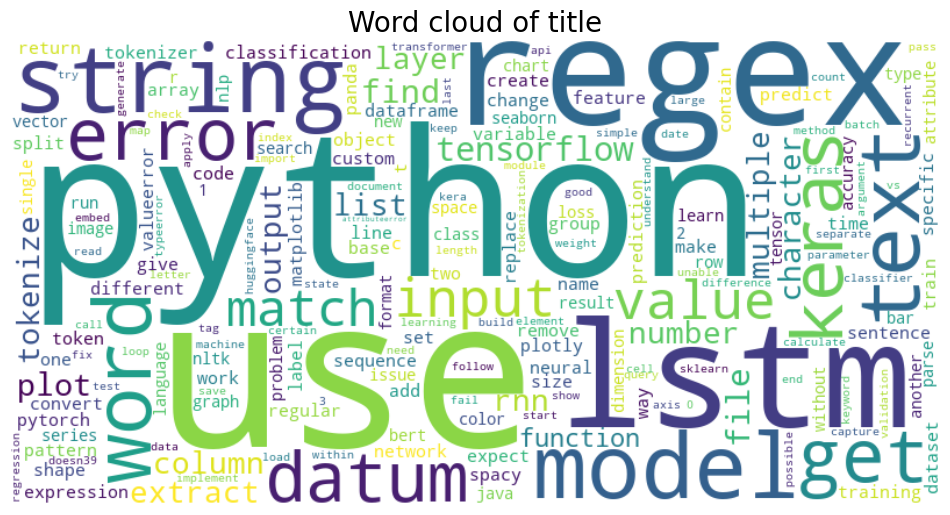

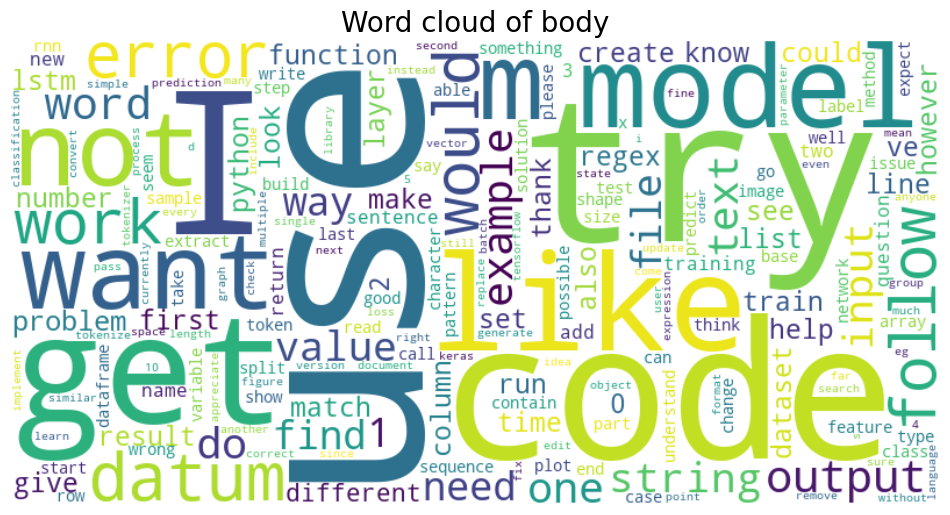

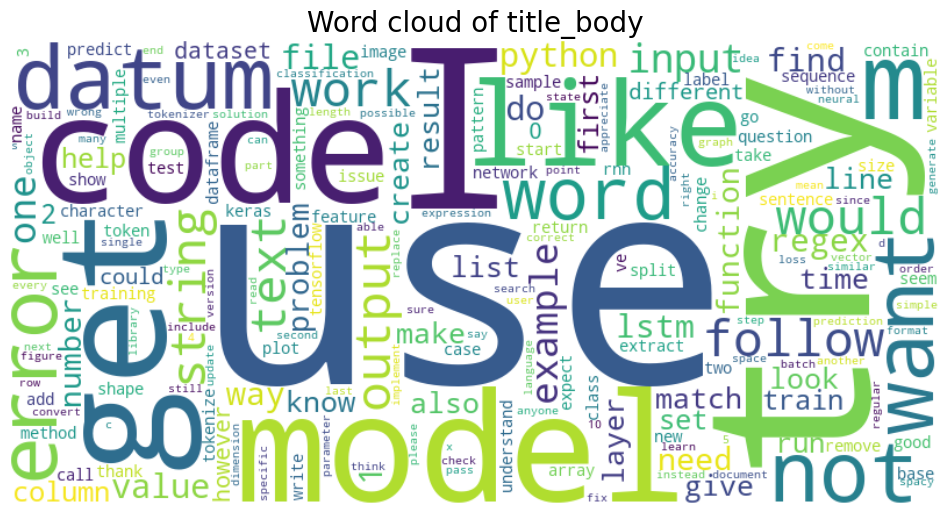

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

# 1. Function to generate word cloud to visualise the most frequent words
def plot_worldcloud(data, feature, num_remove = 0):

    whole_text = " ".join(data[feature])

    # Count word frequencies
    word_freq = Counter(whole_text.split())

    # Remove the top most common words (optional)
    most_common = word_freq.most_common(num_remove)
    for word, _ in most_common:
        del word_freq[word]

    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(12, 8))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'Word cloud of {feature.replace("_stopword", "")}', fontsize=20)
    plt.axis('off')
    plt.show()

# Generate word cloud
plot_worldcloud(tidy_posts_df, "title_stopword")
plot_worldcloud(tidy_posts_df, "body_stopword")
plot_worldcloud(tidy_posts_df, "title_body_stopword")

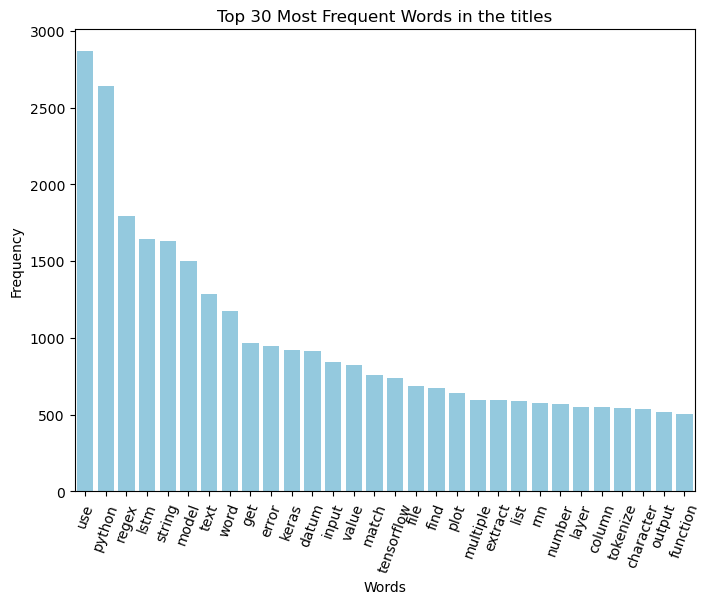

In [ ]:
from collections import Counter
import nltk
import seaborn as sns

# 2. Plot the top N most frequent words in the text
token_series = tidy_posts_df['title_stopword'].copy()
token_series = token_series.apply(lambda x: word_tokenize(x))

# Count word frequencies
all_tokens = [token for tokens in token_series for token in tokens]
counter = Counter(all_tokens)

# Remove the top most common words (optional)
for word, _ in counter.most_common(0):
    del counter[word]

most_com = 30
plt.figure(figsize=(8, 6))
sns.barplot(x=[word for word, _ in counter.most_common(most_com)],
             y=[count for _, count in counter.most_common(most_com)], color="skyblue")
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=70)
plt.title(f'Top {most_com} Most Frequent Words in the titles')
plt.show()


# 4.	Categorisation of the posts

## BERTopic to initialise topic in dataset

In [ ]:
from bertopic import BERTopic

# Your list of post titles
documents = tidy_posts_df["title_stopword"].copy().tolist()

# Create BERTopic model
topic_model = BERTopic()

# Fit the model to your text data
topics, probs = topic_model.fit_transform(documents)

# Inspect the top topics
topic_model.get_topic_info()[1:]

Topic  Count                                            Name  \
1        0    400                    0_panda_dataframe_column_row   
2        1    218               1_regex_regular_expression_python   
3        2    214             2_bert_embedding_bertopic_bertmodel   
4        3    192             3_replace_substre_resub_replacement   
5        4    191  4_stringtokenizer_tokenize_delimiter_tokenizer   
..     ...    ...                                             ...   
294    293     10               293_colorbar_dfplotbarh_color_bar   
295    294     10                   294_form_jquery_weired_drupal   
296    295     10      295_stringregex_python38_data39s_paragraph   
297    296     10                 296_dob_significant_ne_contract   
298    297     10   297_translate_translation_translating_english   

                                        Representation  \
1    [panda, dataframe, column, row, df, replace, v...   
2    [regex, regular, expression, python, match, pa...   
3    [bert, embedding, bertopic, bertmodel, finetun...   
4    [replace, substre, resub, replacement, substri...   
5    [stringtokenizer, tokenize, delimiter, tokeniz...   
..                                                 ...   
294  [colorbar, dfplotbarh, color, bar, barplot, pc...   
295  [form, jquery, weired, drupal, datalist, addev...   
296  [stringregex, python38, data39s, paragraph, el...   
297  [dob, significant, ne, contract, fulltext, pro...   
298  [translate, translation, translating, english,...   

                                   Representative_Docs  
1    [use replace text use regex panda dataframe, g...  
2    [python regular expression 1, use regular expr...  
3    [bert sentence embedding, bert get sentence em...  
4    [python regular expression resub replace match...  
5    [string tokenizer delimiter, java tokenize str...  
..                                                 ...  
294  [get bokeh colorbar show min max value, colorb...  
295  [display master detail form together, jquery f...  
296  [stringregex search excel python issue, use re...  
297  [gate extract ne document german, extract spec...  
298  [translator googletran translate text english,...  

[298 rows x 5 columns]

In [ ]:
# Visualize the topic separation
topic_model.visualize_topics()

In [ ]:
# Reduced the number of topics
topic_model_reduced = topic_model.reduce_topics(documents, nr_topics=20)

# Display the result
topic_df = topic_model_reduced.get_topic_info()
topic_df

Topic  Count                                        Name  \
0      -1   8585                    -1_use_python_lstm_model   
1       0   4269                 0_regex_string_python_match   
2       1   3097                    1_lstm_keras_model_input   
3       2   1491             2_bert_word_text_classification   
4       3   1077            3_plot_matplotlib_seaborn_plotly   
5       4    365      4_attribute_attributeerror_object_name   
6       5    184          5_huggingface_transformer_face_hug   
7       6    166        6_strtok_type_typescript_constructor   
8       7    154            7_autocomplete_material_ui_react   
9       8    130         8_spring_authentication_jax_request   
10      9    117       9_azure_pipeline_powershell_sagemaker   
11     10     97              10_git_docker_container_github   
12     11     54               11_flutter_swiftui_widget_app   
13     12     44                  12_nextjs_react_vue_native   
14     13     39                    13_expect_mock_test_jest   
15     14     38                14_medium_css_tailwind_query   
16     15     35                   15_mongodb_query_sql_join   
17     16     32                    16_thread_hang_call_play   
18     17     15           17_laravel_cms_phpmyadmin_symfony   
19     18     11  18_subsonic_simplerepository_30_connection   

                                       Representation  \
0   [use, python, lstm, model, string, keras, text...   
1   [regex, string, python, match, tokenize, use, ...   
2   [lstm, keras, model, input, tensorflow, layer,...   
3   [bert, word, text, classification, word2vec, s...   
4   [plot, matplotlib, seaborn, plotly, chart, bar...   
5   [attribute, attributeerror, object, name, modu...   
6   [huggingface, transformer, face, hug, model, t...   
7   [strtok, type, typescript, constructor, functi...   
8   [autocomplete, material, ui, react, component,...   
9   [spring, authentication, jax, request, certifi...   
10  [azure, pipeline, powershell, sagemaker, devop...   
11  [git, docker, container, github, dockercompose...   
12  [flutter, swiftui, widget, app, view, swift, b...   
13  [nextjs, react, vue, native, vuejs, page, vite...   
14  [expect, mock, test, jest, testing, result, wo...   
15  [medium, css, tailwind, query, tailwindcss, me...   
16  [mongodb, query, sql, join, update, table, rec...   
17  [thread, hang, call, play, execution, ringtone...   
18  [laravel, cms, phpmyadmin, symfony, web, host,...   
19  [subsonic, simplerepository, 30, connection, r...   

                                  Representative_Docs  
0   [use python separate line text use pattern mat...  
1   [split string base multiple regex match, pytho...  
2   [lstm model valueerror input 0 layer lstm inco...  
3   [use text classification dataframe python, tex...  
4   [line plot seaborn, plot bar chart python, add...  
5   [attributeerror object attribute 39outputtenso...  
6   [use transformer huggingface without tokenizat...  
7   [tokenize string without use strtok, use strto...  
8   [material ui autocomplete custom value, get va...  
9   [customize spring boot error response code wit...  
10  [template error yaml pipeline azure devop, azu...  
11  [splitting commit git, need run multiple conta...  
12  [error import opencv module flutter, flutter s...  
13  [deploy nextjs app without nodejs server, diff...  
14  [get expect regex expression, python regex ret...  
15  [target css ipad exclude safari 4 desktop use ...  
16  [parse complex query sql, find colon separate ...  
17  [java 21 virtual thread address main reason sw...  
18  [homestead laravel call prestashop host machin...  
19  [use subsonic 30 simplerepository exist databa...

## Define Category Dictionary

In [ ]:
category_dict = {
    'preprocessing': ['regex', 'string',  'expression', 'match',  'pattern', 'replace', 'resub', 'substring', 'substitute', 'stringreplace', 'regexsplit', 'regexmatching', 'matching', 'space', 'white', 'character', 'alphanumeric', 'whitespace', 'separator', 'uppercase', 'lowercase', 'capitalize', 'punctuation'],
    'tokenisation': ['tokenize', 'delimiter', 'tokenizer', 'token',  'tokeninput', 'tokenlist', 'tokenization', 'ngram', 'bigram', 'streamtokenizer', 'regextokenizer', 'punkt', 'wordtokenize'],
    'normalisation': ['lemmatization', 'lemma', 'lemmatizer', 'lemmatize', 'stem', 'spacy', 'stanford', 'corenlp', 'stanfordnlp', 'nltk', 'wordnet', 'stopword', 'stopwords', 'stop', 'remove', 'filterstopword', 'removestopwords', 'stopwordremoval', 'textcleaning'],
    'syntatic_annotation': ['pos','tag','tagger','wordpos', 'noun', 'subject', 'adjective', 'nounverbnoun', 'markov', 'tagging', 'entity','recognition', 'ner', 'namedentity', 'entityrecognizer', 'person', 'organization', 'location', 'dependency', 'parser'],
    'vectorisation': ['tfidf', 'tf', 'tfidfvectorizer', 'vector', 'countvectorizer', 'vectorize', 'vectorization', 'bow', 'bagofword', 'bag', 'sparse'],
    'embedding': ['bert', 'embedding',  'embed', 'dense', 'word2vec', 'vector', 'cbow', 'bidirectional', 'bidirection', 'embeddings', 'fasttext'],
    'deep_neural_network': ['rnn', 'rnncell', 'lstm', 'lstmrnn', 'bidirectional', 'bidirection', 'gru', 'attention', 'layers', 'layer', 'recurrent', 'lstminput', 'hug', 'face', 'hugging', 'huggingface', 'transformer', 'weights', 'tensorflow', 'tensor', 'pytorch', 'keras', 'seqtoseq', 'seq2seq', 'descent', 'gradient', 'huggingfacetransformer', 'softmax', 'sigmoid', 'activation', 'tanh', 'relu', 'gradient', 'descent'],
    'machine_learning': ['forest', 'random', 'decision', 'tree', 'scikitlearn', 'scikit', 'sklearn', 'logistic', 'svm', 'naive', 'bayes', 'cluster', 'kmean', 'pca', 'elbow', 'kmeans', 'gridsearchcv', 'grid', 'crossvalidation', 'cross', 'kfold', 'validation', 'sklearn', 'linear', 'regression', 'textblob', 'linearsvc'],
    'topic_modeling_question_answering': ['lda', 'gensim', 'bertopic', 'topic', 'topicmodeling', 'latent', 'dirichlet', 'ldamodel', 'topicdistribution', 'nlptopic', 'gpt3', 'answer', 'gpt', 'prompt', 'question', 'gpt2', 'api', 'openai'],
    'evaluation': ['precision','roc', 'auc', 'f1score', 'score', 'recall', 'confusion', 'matrix', 'accuracy', 'metric', 'evaluation', 'evaluate'],
    'visualisation': ['wordcloud', 'cloud', 'visualize', 'seaborn', 'barplot', 'matplotlib', 'axis', 'tick', 'chart', 'plot']}

In [ ]:
import pandas as pd
from collections import Counter

processed_texts = tidy_posts_df["title_stopword"].copy().tolist()

for i, text in enumerate(processed_texts):
    processed_texts[i] = processed_texts[i].split()

dictionary = corpora.Dictionary(processed_texts)
corpus = [dictionary.doc2bow(text) for text in processed_texts]

# Function to count keyword frequencies using doc2bow
def count_keywords_with_doc2bow(corpus, keyword_list, dictionary):
    keyword_count = Counter()

    # Iterate through the corpus and count occurrences of each keyword
    for doc in corpus:
        for word_id, word_count in doc:
            word = dictionary[word_id]
            if word in keyword_list:
                keyword_count[word] += word_count

    return keyword_count

# Create a dictionary to store keyword frequencies for each category
keyword_frequencies = {}

# Iterate through the dictionary to get counts for each category's keywords
for category, keywords in category_dict.items():
    category_freq = count_keywords_with_doc2bow(corpus, keywords, dictionary)
    keyword_frequencies[category] = category_freq

# Keep only 10 keywords with most frequency for each category
keyword_data = []

for category, freqs in keyword_frequencies.items():
    sorted_keywords = sorted(freqs.items(), key=lambda x: x[1], reverse=True)
    str_keywords = ', '.join(f"{keyword} ({count})" for keyword, count in sorted_keywords)
    keyword_data.append({'Category': category, 'Keywords': str_keywords})

keyword_df = pd.DataFrame(keyword_data)

keyword_df


Category  \
0                       preprocessing   
1                        tokenisation   
2                       normalisation   
3                 syntatic_annotation   
4                       vectorisation   
5                           embedding   
6                 deep_neural_network   
7                    machine_learning   
8   topic_modeling_question_answering   
9                          evaluation   
10                      visualisation   

                                             Keywords  
0   regex (1793), string (1634), match (757), char...  
1   tokenize (543), tokenizer (401), token (343), ...  
2   remove (412), spacy (387), nltk (198), stop (9...  
3   tag (125), entity (112), ner (71), recognition...  
4   vector (177), tfidf (42), countvectorizer (35)...  
5   bert (183), vector (177), embed (145), word2ve...  
6   lstm (1644), keras (923), tensorflow (737), rn...  
7   regression (128), validation (122), sklearn (1...  
8   api (159), gensim (91), question (62), topic (...  
9   accuracy (212), matrix (112), score (85), metr...  
10  plot (639), matplotlib (262), chart (206), sea...

In [ ]:
final_category_dict = {
    'preprocessing': ['regex', 'string', 'match', 'character', 'expression', 'pattern', 'replace', 'space', 'matching', 'substring'],
    'tokenisation': ['tokenize', 'tokenizer', 'token', 'tokenization', 'delimiter', 'ngram', 'bigram', 'wordtokenize', 'streamtokenizer', 'punkt'],
    'normalisation': ['remove', 'spacy', 'nltk', 'stop', 'stanford', 'stopword', 'stem', 'lemmatization', 'corenlp', 'wordnet'],
    'syntatic_annotation': ['tag', 'entity', 'ner', 'recognition', 'parser', 'dependency', 'noun', 'pos', 'location', 'adjective'],
    'vectorisation': ['vector', 'tfidf', 'countvectorizer', 'tf', 'tfidfvectorizer', 'sparse', 'bag', 'vectorize', 'vectorization', 'bow'],
    'embedding': ['bert', 'vector', 'embed', 'word2vec', 'embedding', 'bidirectional', 'fasttext', 'dense', 'cbow', 'embeddings'],
    'deep_neural_network':['lstm', 'keras', 'tensorflow', 'rnn', 'layer', 'pytorch', 'tensor', 'huggingface', 'transformer', 'recurrent'],
    'machine_learning': ['regression', 'validation', 'sklearn', 'scikitlearn', 'tree', 'random', 'cluster', 'linear', 'decision', 'forest'],
    'topic_modeling_question_answering': ['api', 'gensim', 'question', 'topic', 'answer', 'gpt2', 'openai', 'lda', 'prompt', 'gpt3'],
    'evaluation': ['accuracy', 'matrix', 'score', 'metric', 'confusion', 'evaluate', 'evaluation', 'precision', 'recall', 'roc'],
    'visualisation': ['plot', 'matplotlib', 'chart', 'seaborn', 'axis', 'visualize', 'tick', 'cloud', 'barplot', 'wordcloud']}

### 4.1. Rule-based Model

In [ ]:
# Function to perform rule based categorisation
def rule_based_category(df, column, category_keywords):

    result_df = df.copy()

    text_categories = []

    for text in result_df[column]:
        tokens = word_tokenize(text)

        scores = {}

        for category, keywords in category_keywords.items():

            match_count = sum(token in keywords for token in tokens)

            if match_count > 0:
                scores[category] = match_count

        if scores:
            predicted_category = max(scores, key=scores.get)
        else:
            predicted_category = 'other'

        text_categories.append(predicted_category)

    result_df['rule_based_category'] = text_categories

    return result_df


In [ ]:
# Implement the rule based categorisation to the data
rule_based_df = rule_based_category(tidy_posts_df, "title_stopword", final_category_dict)
rule_based_df[["title_stopword", "body_stopword", "rule_based_category"]].head(10)

title_stopword  \
0      mahapps datetimepicker custom datetime format   
1          merge combine two onedit trigger function   
2                use multiple ref array element hook   
3  bookmarklet javascript toggle gmail conversati...   
4    datum arrive call stm32g4 uart receive function   
5               jdbc resultset get column table alia   
6                                stanford nlp python   
7                    store image instead show server   
8             multiple hero share tag within subtree   
9                   measure code execution time code   

                                       body_stopword  rule_based_category  
0  use datetimepicker control mahapps currently s...                other  
1  script google sheet collect interwebs get help...                other  
2  far understand use ref single element like imp...                other  
3  want bookmarklet quickly toggle gmail conversa...                other  
4  data reception lock datum arrive stm32 uart re...                other  
5  imagine query like maybe table column name tho...                other  
6  want find sentiment positivenegativeneutral gi...        normalisation  
7  run code find site server would like store ima...                other  
8  try navigate one screen another route hit butt...  syntatic_annotation  
9  want know much time procedurefunctionorder tak...                other

In [ ]:
# Evaluate the separation for each category from rule based
rule_based_count = rule_based_df["rule_based_category"].value_counts()
rule_based_count

rule_based_category
other                                7668
preprocessing                        3953
deep_neural_network                  3496
visualisation                        1145
tokenisation                         1039
normalisation                         668
machine_learning                      485
embedding                             457
syntatic_annotation                   307
evaluation                            275
topic_modeling_question_answering     270
vectorisation                         237
Name: count, dtype: int64

### 4.2 Cosine Similarity with Sentence BERT Embedding

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Load BERT sentence embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Function to perform categorisation using cosine similarity between sentence embedding of data to each category
def cosine_similarity_sentence_embed(df, column, category_keywords, print_plot=False):

    # Convert keywords to representative category sentences
    category_sentences = {cat: ' '.join(keywords) for cat, keywords in category_keywords.items()}

    # Calculate sentence embedding for each category
    category_embeddings = {category: model.encode(sentence) for category, sentence in category_sentences.items()}

    best_categories = []
    best_scores = []
    similarities = {}

    # Classify each document
    for i, text in enumerate(df[column]):
        # Calculate sentence embedding for the posts
        text_embedding = model.encode(text)

        # Calculate the cosine similarity between sentence embeddings
        similarities[i] = {}
        for category, category_embedding in category_embeddings.items():
            similarity = cosine_similarity([text_embedding], [category_embedding]).item()
            similarities[i][category] = similarity

        # Collect category with the highest cosine similarity
        best_category, best_score = max(similarities[i].items(), key=lambda x: x[1])

        best_categories.append(best_category)
        best_scores.append(best_score)

    # Evaluate the distribution to determine the threshold
    if print_plot:
        all_similarities = [similarity for doc_sim in similarities.values() for similarity in doc_sim.values()]
        plt.hist(all_similarities, bins=30, color='blue', alpha=0.7)
        plt.title('Cosine Similarity Distribution for ' + column)
        plt.xlabel('Cosine Similarity')
        plt.ylabel('Frequency')
        plt.show()

    return best_categories, best_scores

def assign_category_cosine_similarity(df, best_categories, best_scores, threshold=0.3):
    text_categories = []
    result_df = df.copy()

    # Assign category to each posts based on the threshold
    for i, score in enumerate(best_scores):
        if score < threshold:
            text_categories.append('other')
        else:
            text_categories.append(best_categories[i])

    result_df['cosine_category'] = text_categories

    return result_df

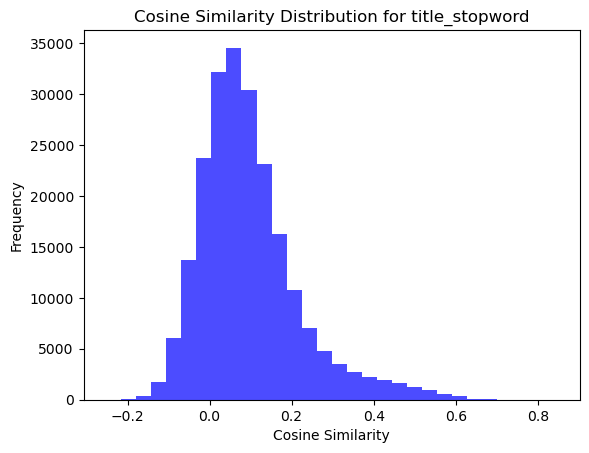

In [ ]:
categories, scores = cosine_similarity_sentence_embed(tidy_posts_df, "title_stopword", final_category_dict, True)

In [ ]:
cosine_sentence_df = assign_category_cosine_similarity(tidy_posts_df, categories, scores, 0.3)
cosine_sentence_df[['title_stopword','cosine_category']].head(10)

title_stopword cosine_category
0      mahapps datetimepicker custom datetime format           other
1          merge combine two onedit trigger function           other
2                use multiple ref array element hook           other
3  bookmarklet javascript toggle gmail conversati...           other
4    datum arrive call stm32g4 uart receive function           other
5               jdbc resultset get column table alia           other
6                                stanford nlp python   normalisation
7                    store image instead show server           other
8             multiple hero share tag within subtree           other
9                   measure code execution time code           other

In [ ]:
# Evaluate the separation for each category from cosine similarity of sentence embeddings
cosine_sentence_count = cosine_sentence_df["cosine_category"].value_counts()
cosine_sentence_count

cosine_category
other                                8633
deep_neural_network                  3337
preprocessing                        2818
tokenisation                         1534
visualisation                        1240
normalisation                         857
embedding                             517
syntatic_annotation                   318
machine_learning                      281
evaluation                            246
vectorisation                         134
topic_modeling_question_answering      85
Name: count, dtype: int64

### 4.3 Model Evaluation

In [ ]:
### SILHOUTTE SCORE

from sentence_transformers import SentenceTransformer
from sklearn.metrics import silhouette_score

# 1. Function to create embedding using Sentence-BERT
def create_embedding(df, text_col):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(df[text_col].tolist(), convert_to_numpy=True)

    return embeddings

# 2. Function to calculate silhoutte score without considering 'other' label
def calculate_silhoutte_score(df, embeddings, label_col, print_result=False):
    mask = df[label_col] != 'other'
    score_without_other = silhouette_score(embeddings[mask], df[label_col][mask])

    if print_result:
        print(f"Silhouette score without 'other': {score_without_other:.3f}")
    else:
        return score_without_other


In [ ]:
# Creating Sentence embedding for title_stopword for fair evaluation calculation
tidy_title_embedding = create_embedding(tidy_posts_df, 'title_stopword')

In [ ]:
# Evaluating the silhoutte score for both model
print("Rule-based model:")
calculate_silhoutte_score(rule_based_df, tidy_title_embedding, 'rule_based_category', True)

print("\nCosine similarity with Sentence-BERT embedding model:")
calculate_silhoutte_score(cosine_sentence_df, tidy_title_embedding, 'cosine_category', True)

Rule-based model:
Silhouette score without 'other': 0.064

Cosine similarity with Sentence-BERT embedding model:
Silhouette score without 'other': 0.091


In [ ]:
### INTRA AND INTER CLUSTER DISTANCE

from sklearn.metrics import pairwise_distances
from collections import defaultdict

# 1. Function to calculate intra and inter cluster distance
def compute_intra_inter_cluster_distances(df, embeddings, label_col, print_result=False):
    label_to_indices = defaultdict(list)

    # Filter out 'other' label
    valid_mask = df[label_col] != 'other'
    filtered_df = df[valid_mask]
    filtered_embeddings = embeddings[valid_mask.to_numpy()]

    # Group data point indices by cluster label
    for idx, label in enumerate(filtered_df[label_col]):
        label_to_indices[label].append(idx)

    cluster_centroids = {}
    intra_dists = []

    # Intra-cluster: Calculate distance between each points to its cluster centroid
    for label, indices in label_to_indices.items():
        cluster_points = filtered_embeddings[indices]
        centroid = np.mean(cluster_points, axis=0)
        cluster_centroids[label] = centroid

        dists = np.linalg.norm(cluster_points - centroid, axis=1)
        intra_dists.extend(dists)

    intra_dist = np.mean(intra_dists)

    # Inter-cluster: Calculate pairwise distances between all cluster centroids
    centroids = np.array(list(cluster_centroids.values()))
    if len(centroids) > 1:
        inter_dists = pairwise_distances(centroids)

        # Remove diagonal, which contain self distance
        inter_dists = inter_dists[np.triu_indices_from(inter_dists, k=1)]
        inter_dist = np.mean(inter_dists)
    else:
        # If there is only one cluster, making no pairwise calculation
        inter_dist = 0.0

    if print_result:
        print("Average Intra-cluster Distance:", intra_dist)
        print("Average Inter-cluster Distance:", inter_dist)
    else:
        return intra_dist, inter_dist

In [ ]:
# Evaluating the intra and inter cluster distance for both model
print("Rule-based model:")
compute_intra_inter_cluster_distances(rule_based_df, tidy_title_embedding, 'rule_based_category', True)

print("\nCosine similarity with Sentence-BERT embedding model:")
compute_intra_inter_cluster_distances(cosine_sentence_df, tidy_title_embedding, 'cosine_category', True)

Rule-based model:
Average Intra-cluster Distance: 0.84261286
Average Inter-cluster Distance: 0.5161489

Cosine similarity with Sentence-BERT embedding model:
Average Intra-cluster Distance: 0.80869186
Average Inter-cluster Distance: 0.6100092


### 4.4 Experiment

In [ ]:
# Define column names that will be used to experiment
cols_to_test = ['title_regex', 'title_lowercase', 'title_lemmatisation', 'title_stopword', 'body_stopword', 'title_body_stopword']

In [ ]:
# Calculating Sentence embedding for each experimentation column for uniform evaluation calculation
embedding_to_test = []

for col in cols_to_test:
    embedding_to_test.append(create_embedding(tidy_posts_df, col))

In [ ]:
# Function to perform model evaluation with different combination
def experiment_model(model_to_exp, label_col, cols_to_test, embedding_to_test, combined_category=None, combined_score=None):

    combination_model_result = tidy_posts_df.copy()
    category_freq_dict = {}
    silhouette_score_dict = {}
    intra_distance_dict = {}
    inter_distance_dict = {}

    for i, col in enumerate(cols_to_test):
        if model_to_exp == 'rule_based':
            curr_model_df = rule_based_category(tidy_posts_df, col, final_category_dict)
        else:
            curr_model_df = assign_category_cosine_similarity(tidy_posts_df, combined_category[i], combined_score[i])

        result_col = col + "_" + label_col

        combination_model_result[result_col] = curr_model_df[label_col]

        # Count frequency of each category and store it
        category_counts = curr_model_df[label_col].value_counts()
        category_freq_dict[result_col] = category_counts

        # Calculate the silhoutte score
        curr_silhouette_score = calculate_silhoutte_score(curr_model_df, embedding_to_test[i], label_col)
        silhouette_score_dict[result_col] = f"**{curr_silhouette_score:.3f}**"

        # Calculate intra and inter cluster distance
        curr_intra, curr_inter = compute_intra_inter_cluster_distances(curr_model_df, embedding_to_test[i], label_col)
        intra_distance_dict[result_col] = f"**{curr_intra:.3f}**"
        inter_distance_dict[result_col] = f"**{curr_inter:.3f}**"

    category_freq_df = pd.DataFrame(category_freq_dict).fillna(0).astype(int)

    other_row = category_freq_df.loc[['other']]
    rest = category_freq_df.drop(index='other')
    category_freq_df = pd.concat([other_row, rest])

    silhouette_row = pd.DataFrame(silhouette_score_dict, index=['silhouette_score_without_other'])
    intra_row = pd.DataFrame(intra_distance_dict, index=['intra_distance'])
    inter_row = pd.DataFrame(inter_distance_dict, index=['inter_distance'])
    category_freq_df = pd.concat([category_freq_df, silhouette_row, intra_row, inter_row])

    return category_freq_df


#### 4.4.1 Rule-based

In [ ]:
# Evaluate the category separation and evaluation metrics for the rule based model
rule_based_exp_df = experiment_model('rule_based', 'rule_based_category', cols_to_test, embedding_to_test)
rule_based_exp_df

title_regexrule_based_category  \
other                                                      12810   
deep_neural_network                                         1043   
embedding                                                    261   
evaluation                                                   277   
machine_learning                                             397   
normalisation                                                318   
preprocessing                                               2997   
syntatic_annotation                                          165   
tokenisation                                                 662   
topic_modeling_question_answering                            113   
vectorisation                                                128   
visualisation                                                829   
silhouette_score_without_other                         **0.060**   
intra_distance                                         **0.842**   
inter_distance                                         **0.524**   

                                  title_lowercaserule_based_category  \
other                                                           8491   
deep_neural_network                                             3511   
embedding                                                        458   
evaluation                                                       231   
machine_learning                                                 467   
normalisation                                                    661   
preprocessing                                                   3607   
syntatic_annotation                                              232   
tokenisation                                                     839   
topic_modeling_question_answering                                258   
vectorisation                                                    215   
visualisation                                                   1030   
silhouette_score_without_other                             **0.067**   
intra_distance                                             **0.841**   
inter_distance                                             **0.526**   

                                  title_lemmatisationrule_based_category  \
other                                                               7614   
deep_neural_network                                                 3508   
embedding                                                            454   
evaluation                                                           275   
machine_learning                                                     481   
normalisation                                                        666   
preprocessing                                                       3961   
syntatic_annotation                                                  315   
tokenisation                                                        1072   
topic_modeling_question_answering                                    270   
vectorisation                                                        236   
visualisation                                                       1148   
silhouette_score_without_other                                 **0.064**   
intra_distance                                                 **0.848**   
inter_distance                                                 **0.513**   

                                  title_stopwordrule_based_category  \
other                                                          7668   
deep_neural_network                                            3496   
embedding                                                       457   
evaluation                                                      275   
machine_learning                                                485   
normalisation                                                   668   
preprocessing                                                  3953   
syntati

### 4.4.2 Cosine similarity

In [ ]:
combined_category = []
combined_score = []

for col in cols_to_test:
    categories, scores = cosine_similarity_sentence_embed(tidy_posts_df, col, final_category_dict)
    print(f"{col} done calculating.")

    combined_category.append(categories)
    combined_score.append(scores)

title_regex done calculating.
title_lowercase done calculating.
title_lemmatisation done calculating.
title_stopword done calculating.
body_stopword done calculating.
title_body_stopword done calculating.


In [ ]:
# Evaluate the category separation and evaluation metrics for the cosine similarity model
cos_sim_exp_df = experiment_model('cos_sim', 'cosine_category', cols_to_test, embedding_to_test, combined_category, combined_score)
cos_sim_exp_df

title_regex_cosine_category  \
other                                                    8696   
deep_neural_network                                      3361   
embedding                                                 525   
evaluation                                                216   
machine_learning                                          256   
normalisation                                             863   
preprocessing                                            2853   
syntatic_annotation                                       319   
tokenisation                                             1522   
topic_modeling_question_answering                          73   
vectorisation                                             133   
visualisation                                            1183   
silhouette_score_without_other                      **0.090**   
intra_distance                                      **0.811**   
inter_distance                                      **0.619**   

                                  title_lowercase_cosine_category  \
other                                                        8696   
deep_neural_network                                          3361   
embedding                                                     525   
evaluation                                                    216   
machine_learning                                              256   
normalisation                                                 863   
preprocessing                                                2853   
syntatic_annotation                                           319   
tokenisation                                                 1522   
topic_modeling_question_answering                              73   
vectorisation                                                 133   
visualisation                                                1183   
silhouette_score_without_other                          **0.090**   
intra_distance                                          **0.811**   
inter_distance                                          **0.619**   

                                  title_lemmatisation_cosine_category  \
other                                                            8898   
deep_neural_network                                              3273   
embedding                                                         508   
evaluation                                                        218   
machine_learning                                                  240   
normalisation                                                     783   
preprocessing                                                    2838   
syntatic_annotation                                               326   
tokenisation                                                     1527   
topic_modeling_question_answering                                  74   
vectorisation                                                     131   
visualisation                                                    1184   
silhouette_score_without_other                              **0.092**   
intra_distance                                              **0.812**   
inter_distance                                              **0.617**   

                                  title_stopword_cosine_category  \
other                                                       8633   
deep_neural_network                                         3337   
embedding                                                    517   
evaluation                                                   246   
machine_learning                                             281   
normalisation                                                857   
preprocessing                                               2818   
syntatic_annotation                                          318   
tokenisation                                                1534   
topic_modeling_question_answering      

### 4.4.3 Incorporating POS tags and Dependency Parsing

In [ ]:
import spacy
# Load spaCy model and SentenceTransformer
nlp = spacy.load("en_core_web_sm")

# POS-enhanced text processing
def extract_relevant_tag(text):
    doc = nlp(text)
    relevant_tokens = [
        token.text
        for token in doc
        if token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'}
    ]
    return ' '.join(relevant_tokens)

# POS tags with dependency parsing
def extract_relevant_tag_with_dep(text):
    doc = nlp(text)
    relevant_tokens = [
        token.text
        for token in doc
        if token.pos_ in {'NOUN', 'PROPN', 'VERB', 'ADJ'} and token.dep_ in {'nsubj', 'dobj', 'ROOT', 'compound', 'amod'}
    ]
    return ' '.join(relevant_tokens)

In [ ]:
tidy_posts_df['title_pos_tag'] = tidy_posts_df['title_lemmatisation'].copy().apply(lambda x: extract_relevant_tag(x))
tidy_posts_df['title_pos_tag_dep'] = tidy_posts_df['title_lemmatisation'].copy().apply(lambda x: extract_relevant_tag_with_dep(x))

add_cols_to_test = ['title_pos_tag', 'title_pos_tag_dep']

for col in add_cols_to_test:
    categories, scores = cosine_similarity_sentence_embed(tidy_posts_df, col, final_category_dict)

    combined_category.append(categories)
    combined_score.append(scores)

In [ ]:
# Calculating Sentence embedding for pos tags and dependency columns
add_embedding_to_test = []

for col in add_cols_to_test:
    add_embedding_to_test.append(create_embedding(tidy_posts_df, col))

In [ ]:
# Evaluate the category separation and evaluation metrics for the new columns
add_cos_sim_exp_df = experiment_model('cos_sim', 'cosine_category', add_cols_to_test, add_embedding_to_test, combined_category[:-2], combined_score[:-2])
add_cos_sim_exp_df

title_pos_tag_cosine_category  \
other                                                      8696   
deep_neural_network                                        3361   
preprocessing                                              2853   
tokenisation                                               1522   
visualisation                                              1183   
normalisation                                               863   
embedding                                                   525   
syntatic_annotation                                         319   
machine_learning                                            256   
evaluation                                                  216   
vectorisation                                               133   
topic_modeling_question_answering                            73   
silhouette_score_without_other                        **0.089**   
intra_distance                                        **0.811**   
inter_distance                                        **0.607**   

                                  title_pos_tag_dep_cosine_category  
other                                                          8696  
deep_neural_network                                            3361  
preprocessing                                                  2853  
tokenisation                                                   1522  
visualisation                                                  1183  
normalisation                                                   863  
embedding                                                       525  
syntatic_annotation                                             319  
machine_learning                                                256  
evaluation                                                      216  
vectorisation                                                   133  
topic_modeling_question_answering                                73  
silhouette_score_without_other                            **0.061**  
intra_distance                                            **0.851**  
inter_distance                                            **0.519**

### 4.4.4 Preview of the categorisation from the best model

In [ ]:
lemma_cos_sim_model_df = assign_category_cosine_similarity(tidy_posts_df, combined_category[2], combined_score[2])

In [ ]:
pd.set_option('display.max_colwidth', 1000)

def sample_examples_per_category(df, label_col, n=5, random_state=42):

    sample_df = df.groupby(label_col).apply(lambda x: x.sample(min(n, len(x)), random_state=random_state)).reset_index(drop=True)

    return sample_df[[label_col, 'title', 'body']]

lemma_cos_sim_sample_df = sample_examples_per_category(lemma_cos_sim_model_df, 'cosine_category', 5)
lemma_cos_sim_sample_df


cosine_category  \
0                 deep_neural_network   
1                 deep_neural_network   
2                 deep_neural_network   
3                 deep_neural_network   
4                 deep_neural_network   
5                           embedding   
6                           embedding   
7                           embedding   
8                           embedding   
9                           embedding   
10                         evaluation   
11                         evaluation   
12                         evaluation   
13                         evaluation   
14                         evaluation   
15                   machine_learning   
16                   machine_learning   
17                   machine_learning   
18                   machine_learning   
19                   machine_learning   
20                      normalisation   
21                      normalisation   
22                      normalisation   
23                      normalisation   
24                      normalisation   
25                              other   
26                              other   
27                              other   
28                              other   
29                              other   
30                      preprocessing   
31                      preprocessing   
32                      preprocessing   
33                      preprocessing   
34                      preprocessing   
35                syntatic_annotation   
36                syntatic_annotation   
37                syntatic_annotation   
38                syntatic_annotation   
39                syntatic_annotation   
40                       tokenisation   
41                       tokenisation   
42                       tokenisation   
43                       tokenisation   
44                       tokenisation   
45  topic_modeling_question_answering   
46  topic_modeling_question_answering   
47  topic_modeling_question_answering   
48  topic_modeling_question_answering   
49  topic_modeling_question_answering   
50                      vectorisation   
51                      vectorisation   
52                      vectorisation   
53                      vectorisation   
54                      vectorisation   
55                      visualisation   
56                      visualisation   
57                      visualisation   
58                      visualisation   
59                      visualisation   

                                                                                                                         title  \
0                                           Format time-series data for short term forecasting using Recurrent Neural networks   
1                                                                           split dataset into train and test using tensorflow   
2                                                                           TF 2.0 LSTM: How to use for a Spending prediction?   
3                                                                                        LSTM Prediction on Sub-Sequences Fail   
4                                       Why is the network not learning as effective (Tensorflow - LSTMs for text generation)?   
5                          Classic king - man + woman = queen example with pretrained word-embedding and word2vec package in R   
6                                                         How to use additional features along with word embeddings in Keras ?   
7                                                           Convolutional neural network for multi-classes text classification   
8                                                 Why do I get inconsistent results between Fasttext, Longformer, and Doc2vec?   
9             Upload a pre-trained spanish language word vectors and then retrain it with custom sentences? (GENSIM -FASTTEXT)   
10                                                                               Changing 

### 4.4 Zero-shot Classification (later, maybe not)

In [ ]:
category_descriptive_keywords = {
    'preprocessing': 'Text preprocessing involving regex, string manipulation, and pattern matching',
    'tokenisation': 'Tokenization and splitting text into words or tokens using delimiters and n-grams',
    'normalisation': 'Text normalization including stop-word removal, stemming, and lemmatization',
    'syntatic_annotation': 'Syntactic annotation with tagging, dependency parsing, and named entity recognition',
    'vectorisation': 'Text vectorization converting text into numerical features (TF-IDF, bag-of-words)',
    'embedding': 'Word embeddings and dense representations such as BERT, Word2Vec, or FastText',
    'deep_neural_network': 'Deep neural network architectures including LSTM, RNN, transformers, and related frameworks',
    'machine_learning': 'Machine learning techniques like regression, clustering, decision trees, and ensemble methods',
    'topic_modeling_question_answering': 'Topic modeling and question answering methods using models like LDA and GPT',
    'evaluation': 'Evaluation metrics such as accuracy, precision, recall, confusion matrices, and model scoring',
    'visualisation': 'Data visualization using plots, charts, word clouds, and other graphical representations',
    'other': 'Other topics not in the list'
}


In [ ]:
from sentence_transformers import SentenceTransformer, util

model = SentenceTransformer("all-MiniLM-L6-v2")

# Convert your label dictionary to descriptions
category_sentences = {cat: ' '.join(keywords) for cat, keywords in final_category_dict.items()}
category_sentences['other'] = 'other topics not in the list'

# Prepare candidate label embeddings
labels = list(category_sentences.keys())
descriptions = list(category_sentences.values())
label_embeddings = model.encode(descriptions, normalize_embeddings=True)

def classify(text):
    text_embedding = model.encode(text, normalize_embeddings=True)
    similarities = util.cos_sim(text_embedding, label_embeddings)[0]
    best_idx = similarities.argmax()
    return labels[best_idx], similarities[best_idx].item()

text = "I am trying to remove unnecessary spaces and unwanted characters from my text using regex."
label, score = classify(text)
print("Predicted Label:", label)
print("Score:", score)


Predicted Label: preprocessing
Score: 0.6505630016326904


In [ ]:
from transformers import pipeline

# Convert keywords to representative category sentences
category_sentences = {cat: ' '.join(keywords) for cat, keywords in final_category_dict.items()}
category_sentences['other'] = 'other topics not in the list'

# Create a zero-shot classifier instance
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli")

# Use the descriptive labels as candidate labels
candidate_labels = list(category_sentences.values())

text = "I am trying to remove unnecessary spaces and unwanted characters from my text using regex."
result = classifier(text, candidate_labels, multi_label=False)

print("Predicted Label:", result["labels"][0])
# print("Scores:", list(zip(result["labels"], result["scores"])))

# def classify_text(text):
#     result = classifier(text, candidate_labels, multi_label=False)
#     return result['labels'][0]  # top prediction only

# tqdm.pandas()
# df['predicted_label'] = df['text'].progress_apply(classify_text)

# # Show the results
# print(df)


# References:

1. https://api.stackexchange.com/docs
2. https://stackoverflow.com/help/accepted-answer
3. https://stackoverflow.com/help/tagging
4. https://api.stackexchange.com/docs/advanced-search#order=desc&sort=activity&accepted=True&tagged=nlp&filter=default&site=stackoverflow&run=true
2. https://api.stackexchange.com/docs/paging
3. https://api.stackexchange.com/docs/answers-by-ids
4. https://medium.com/@davidlfliang/intro-getting-started-with-text-embeddings-using-bert-9f8c3b98dee6
